#  Решение задачи классификации при помощи пакета `torch`.

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/docs/stable/nn.html
* https://pytorch.org/docs/stable/optim.html
* https://lightning.ai/docs/torchmetrics/stable/
* https://pytorch.org/docs/stable/generated/torch.no_grad.html
* https://www.learnpytorch.io/02_pytorch_classification/
* https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler
* https://towardsdatascience.com/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb45
* https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
* https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b7
* https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
* https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss52

## Задачи для совместного разбора

In [1]:
# from torchtyping import TensorType, patch_typeguard
# from typeguard import typechecked
import torch as th

# Scalar = TensorType[()]
# patch_typeguard()

1\. Обсудите подходы к решению задачи классификации на примере синтетического датасета.

In [2]:
num_samples = 1000
num_features = 10
num_classes = 3

X = th.randn(num_samples, num_features)
y = th.randint(0, num_classes, (num_samples, ))

In [3]:
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self, n_inputs: int, n_classes: int) -> None:
        super().__init__()
        self.fc1 = nn.Linear(n_inputs, n_classes)

    def forward(self, X: th.Tensor) -> th.Tensor:
        return self.fc1(X)

In [4]:
model = Classifier(num_features, num_classes)
preds = model(X)
preds.shape

torch.Size([1000, 3])

In [5]:
preds[:5]

tensor([[-0.5825, -0.2694, -0.1900],
        [-0.3070,  0.9153, -0.9206],
        [ 0.3036,  0.0821,  0.0233],
        [ 0.0242, -0.3026, -0.6411],
        [ 0.1846, -0.4930, -0.4736]], grad_fn=<SliceBackward0>)

In [6]:
preds.argmax(dim=1)[:5]

tensor([2, 1, 0, 0, 0])

In [7]:
y[:5]

tensor([2, 1, 0, 1, 0])

In [8]:
criterion = nn.CrossEntropyLoss()
loss = criterion(preds, y)

In [9]:
num_samples = 1000
num_features = 10
num_classes = 2

X = th.randn(num_samples, num_features)
y = th.randint(0, num_classes, (num_samples, ))

In [10]:
import torch.nn as nn

class Classifier(nn.Module):
    def __init__(self, n_inputs: int, n_classes: int) -> None:
        super().__init__()
        self.fc1 = nn.Linear(n_inputs, n_classes)

    def forward(self, X: th.Tensor) -> th.Tensor:
        return self.fc1(X)

In [11]:
model = Classifier(num_features, 1)
preds = model(X)

In [12]:
preds.shape

torch.Size([1000, 1])

In [13]:
preds.sigmoid()[:5]

tensor([[0.2146],
        [0.4392],
        [0.3864],
        [0.5805],
        [0.6152]], grad_fn=<SliceBackward0>)

In [14]:
(preds.sigmoid() >= 0.5)[:5]

tensor([[False],
        [False],
        [False],
        [ True],
        [ True]])

In [15]:
y[:5]

tensor([1, 0, 0, 0, 1])

In [16]:
criterion = nn.BCEWithLogitsLoss()
criterion(preds.flatten(), y.float())

tensor(0.7312, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Используя реализацию полносвязного слоя из `torch.nn`, решите задачу классификации. Разделите датасет на обучающую и тестовую выборку в соотношении 80% на 20%. В качестве функции потерь используйте реализацию `CrossEntropyLoss` из `torch.nn`. Для настройки весов реализуйте мини-пакетный градиентный спуск с использованием `torch.optim.SGD`.

Используйте модель, состоящую из двух слоев:
1. Полносвязный слой с 10 нейронами;
2. Полносвязный слой с 2 нейронами.

Выведите график изменения значения функции потерь в процессе обучения. Выведите на экран значения Accuracy, Precision, Recall и F1 для обучающего и тестового множества.

Выведите на экран облако точек с цветом, соответствующим предсказаниям модели на всем датасете (и обучающей, и тестовой части).

- [x] Проверено на семинаре

In [17]:
from torch.utils.data import random_split, TensorDataset, DataLoader
from sklearn.datasets import make_circles
from matplotlib import pyplot as plt
from torch import nn, optim
import torchmetrics as M
import seaborn as sns
import numpy as np

X, y = make_circles(n_samples=1000, noise=0.05, random_state=42)
X = th.FloatTensor(X)
y = th.LongTensor(y)

In [18]:
dataset = TensorDataset(X, y)
dataset_train, dataset_test = random_split(dataset, [0.8, 0.2])
dataloader_train, dataloader_test = \
    DataLoader(dataset_train, batch_size=125, shuffle=True), DataLoader(dataset_test, batch_size=125, shuffle=True)

In [19]:
model = nn.Sequential(
    nn.Linear(2, 10),
    # nn.ReLU(),
    nn.Linear(10, 2)
)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [20]:
def train(model, criterion, optimizer, loader, n_epochs=10000, print_every=100):
    epoch_losses = []
    for epoch in range(n_epochs + 1):
        model.train()
        accum_losses = []
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            accum_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss = np.mean(accum_losses)
        epoch_losses.append(epoch_loss)
        
        if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{n_epochs}], Loss: {loss.item():.4f}')
    return epoch_losses

In [21]:
def plot(epoch_losses, window_size=50):
    smoothed_losses = np.convolve(epoch_losses, np.ones(window_size) / window_size, mode='valid')
    plt.figure(figsize=(10, 5))
    plt.plot(smoothed_losses, label=f'Скользящее среднее', linewidth=2)
    plt.title('График изменения значения функции потерь')
    plt.xlabel('Эпоха')
    plt.ylabel('Значение функции потерь')
    plt.grid(True)
    plt.legend()
    plt.show()

Epoch [0/2500], Loss: 0.7013
Epoch [500/2500], Loss: 0.6958
Epoch [1000/2500], Loss: 0.6916
Epoch [1500/2500], Loss: 0.6924
Epoch [2000/2500], Loss: 0.6914
Epoch [2500/2500], Loss: 0.6936


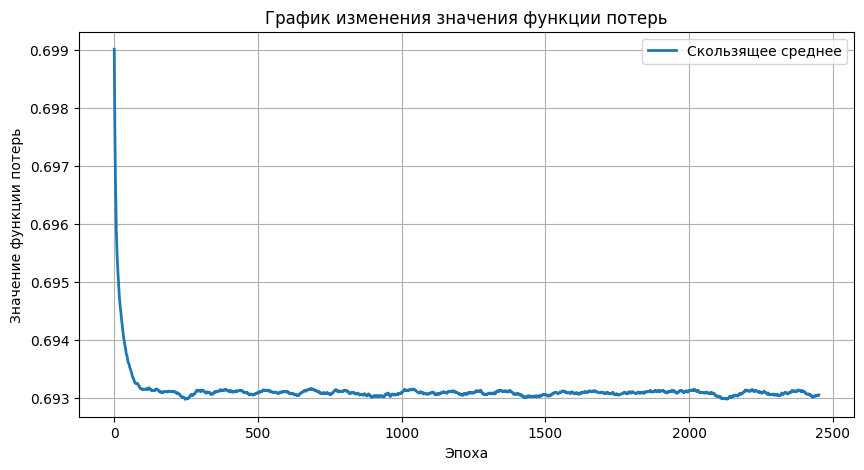

In [22]:
losses = train(model, criterion, optimizer, dataloader_train, 2500, 500)
plot(losses)

In [23]:
def get_metrics(model, dataset_train, dataset_test):
    y_pred_train = model(dataset_train[:][0]).argmax(dim=1)
    y_true_train = dataset_train[:][1]
    print('dataset_train:'.upper())
    for metric in [M.Accuracy('binary'), M.Precision('binary'), M.Recall('binary'), M.F1Score('binary')]:
        print(f'{metric.__class__.__name__}: {metric(y_pred_train, y_true_train).item():.4f}')
    
    y_pred_test = model(dataset_test[:][0]).argmax(dim=1)
    y_true_test = dataset_test[:][1]
    print('\ndataset_test:'.upper())
    for metric in [M.Accuracy('binary'), M.Precision('binary'), M.Recall('binary'), M.F1Score('binary')]:
        print(f'{metric.__class__.__name__}: {metric(y_pred_test, y_true_test).item():.4f}')

In [24]:
get_metrics(model, dataset_train, dataset_test)

DATASET_TRAIN:
BinaryAccuracy: 0.5213
BinaryPrecision: 0.5199
BinaryRecall: 0.5860
BinaryF1Score: 0.5510

DATASET_TEST:
BinaryAccuracy: 0.4550
BinaryPrecision: 0.4621
BinaryRecall: 0.6162
BinaryF1Score: 0.5281


In [25]:
y_pred = model(dataset[:][0]).argmax(dim=1)
y_pred.shape

torch.Size([1000])

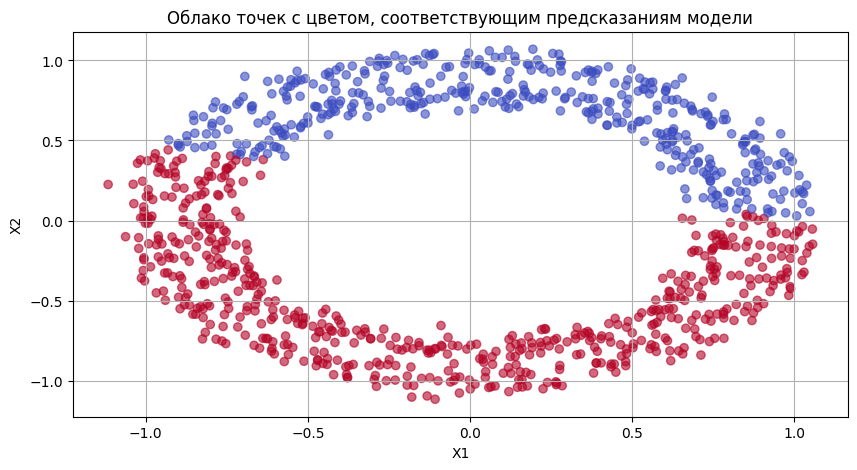

In [26]:
plt.figure(figsize=(10, 5))
plt.scatter(dataset[:][0][:, 0], dataset[:][0][:, 1], c=y_pred, cmap='coolwarm', alpha=0.6)
plt.title('Облако точек с цветом, соответствующим предсказаниям модели')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.show()

<p class="task" id="2"></p>

2\. Повторите задачу 1, используя другую архитектуру нейронной сети.

1. Полносвязный слой с 10 нейронами;
2. Функция активации ReLU;
3. Полносвязный слой с 2 нейронами.

- [x] Проверено на семинаре

In [27]:
model = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 2)
)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

Epoch [0/2500], Loss: 0.7076
Epoch [500/2500], Loss: 0.6836
Epoch [1000/2500], Loss: 0.6384
Epoch [1500/2500], Loss: 0.6276
Epoch [2000/2500], Loss: 0.4987
Epoch [2500/2500], Loss: 0.3925


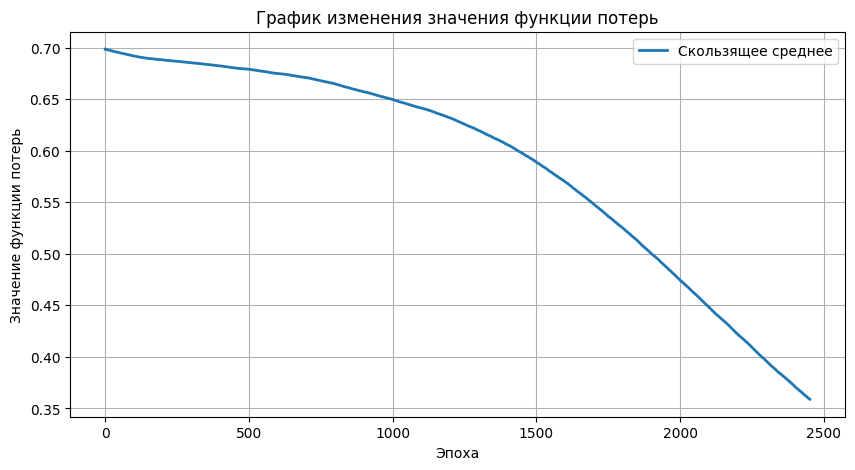

In [28]:
losses = train(model, criterion, optimizer, dataloader_train, 2500, 500)
plot(losses)

In [29]:
get_metrics(model, dataset_train, dataset_test)

DATASET_TRAIN:
BinaryAccuracy: 0.9488
BinaryPrecision: 0.9390
BinaryRecall: 0.9601
BinaryF1Score: 0.9494

DATASET_TEST:
BinaryAccuracy: 0.9600
BinaryPrecision: 0.9505
BinaryRecall: 0.9697
BinaryF1Score: 0.9600


In [30]:
y_pred = model(dataset[:][0]).argmax(dim=1)
y_pred.shape

torch.Size([1000])

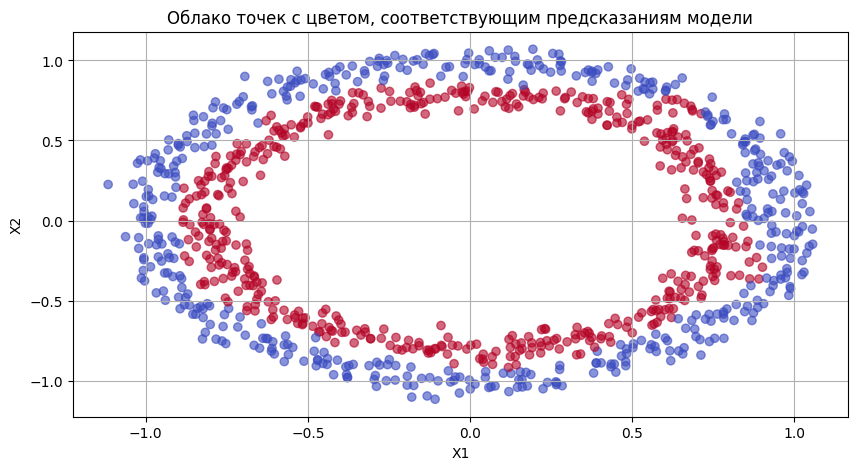

In [31]:
plt.figure(figsize=(10, 5))
plt.scatter(dataset[:][0][:, 0], dataset[:][0][:, 1], c=y_pred, cmap='coolwarm', alpha=0.6)
plt.title('Облако точек с цветом, соответствующим предсказаниям модели')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.show()

<p class="task" id="3"></p>

3\. `CrossEntropyLoss` может быть использована для задачи классификации на любое количество классов. Для задачи бинарной классификации существуют специфические функции потерь. Решите задачу 2, используя `BCEWithLogitsLoss` в качестве функции потерь.

- [x] Проверено на семинаре

In [32]:
def train_alt(model, criterion, optimizer, loader, n_epochs=10000, print_every=100):
    epoch_losses = []
    for epoch in range(n_epochs + 1):
        model.train()
        accum_losses = []
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.unsqueeze(1).float())
            accum_losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_loss = np.mean(accum_losses)
        epoch_losses.append(epoch_loss)
        
        if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{n_epochs}], Loss: {loss.item():.4f}')
    return epoch_losses

In [33]:
def get_metrics_alt(model, dataset_train, dataset_test, threshold=0.5):
    y_pred_train = (model(dataset_train[:][0]).sigmoid() > threshold).squeeze(1).int()
    y_true_train = dataset_train[:][1]
    print('dataset_train:'.upper())
    for metric in [M.Accuracy('binary'), M.Precision('binary'), M.Recall('binary'), M.F1Score('binary')]:
        print(f'{metric.__class__.__name__}: {metric(y_pred_train, y_true_train).item():.4f}')
    
    y_pred_test = (model(dataset_test[:][0]).sigmoid() > threshold).squeeze(1).int()
    y_true_test = dataset_test[:][1]
    print('\ndataset_test:'.upper())
    for metric in [M.Accuracy('binary'), M.Precision('binary'), M.Recall('binary'), M.F1Score('binary')]:
        print(f'{metric.__class__.__name__}: {metric(y_pred_test, y_true_test).item():.4f}')

In [34]:
model = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.BCEWithLogitsLoss()

Epoch [0/2500], Loss: 0.7067
Epoch [500/2500], Loss: 0.2090
Epoch [1000/2500], Loss: 0.0756
Epoch [1500/2500], Loss: 0.0462
Epoch [2000/2500], Loss: 0.1252
Epoch [2500/2500], Loss: 0.1175


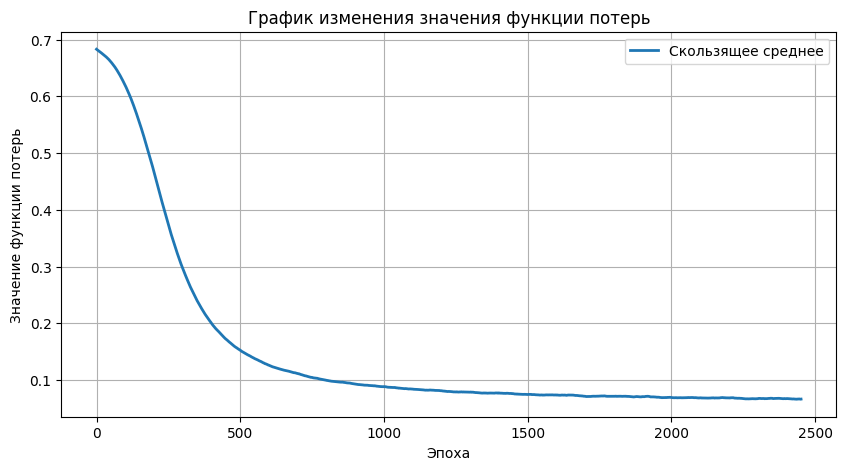

In [35]:
losses = train_alt(model, criterion, optimizer, dataloader_train, 2500, 500)
plot(losses)

In [36]:
get_metrics_alt(model, dataset_train, dataset_test)

DATASET_TRAIN:
BinaryAccuracy: 0.9762
BinaryPrecision: 0.9848
BinaryRecall: 0.9676
BinaryF1Score: 0.9761

DATASET_TEST:
BinaryAccuracy: 0.9600
BinaryPrecision: 0.9505
BinaryRecall: 0.9697
BinaryF1Score: 0.9600


In [37]:
y_pred = model(dataset[:][0]).sigmoid() > 0.5
y_pred.shape

torch.Size([1000, 1])

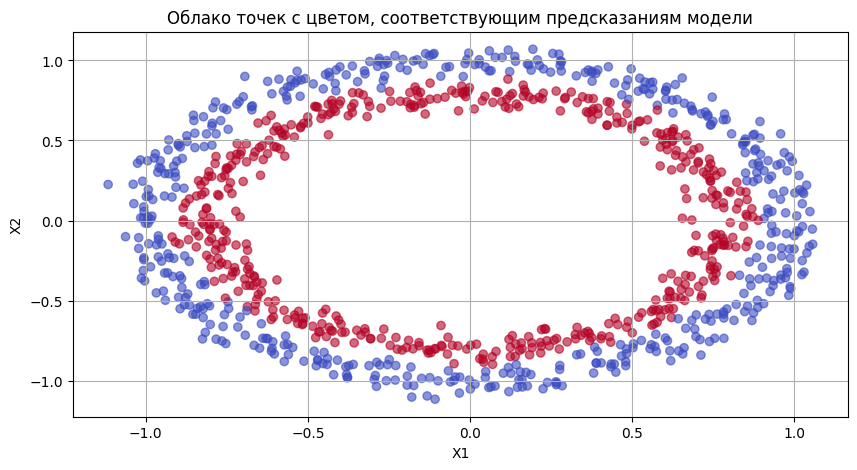

In [38]:
plt.figure(figsize=(10, 5))
plt.scatter(dataset[:][0][:, 0], dataset[:][0][:, 1], c=y_pred, cmap='coolwarm', alpha=0.6)
plt.title('Облако точек с цветом, соответствующим предсказаниям модели')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.show()

<p class="task" id="4"></p>

4\. На практике часто задача классификации является несбалансированной. В файлах каталога `imb_task` содержится несбалансированный набор данных. Обучите модель без учета несбалансированности классов (аналогично предыдущим заданиям, можно использовать любую подходящую функцию потерь). Повысьте качество модели (в смысле F1) путем модификации функции потерь (указания специального аргумента, позволяющего учесть несбалансированность классов).

- [x] Проверено на семинаре

In [39]:
X = th.load('./../data/imb_task/imb_X.th', weights_only=True).float()
y = th.load('./../data/imb_task/imb_y.th', weights_only=True).long()

In [40]:
dataset = TensorDataset(X, y)
dataset_train, dataset_test = random_split(dataset, [0.8, 0.2])
dataloader_train, dataloader_test = \
    DataLoader(dataset_train, batch_size=125, shuffle=True), \
    DataLoader(dataset_test, batch_size=125, shuffle=True)

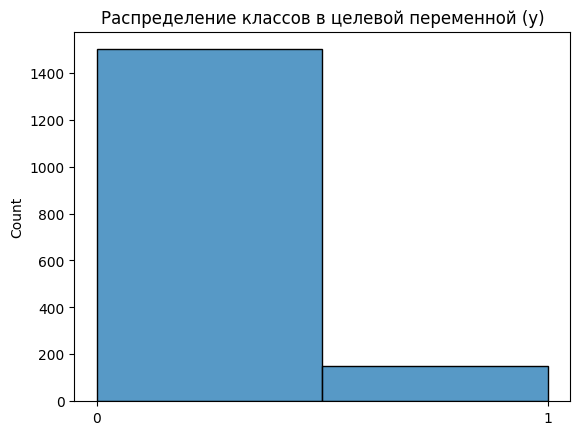

In [41]:
plt.title('Распределение классов в целевой переменной (y)')
sns.histplot(y.tolist(), bins=2)
plt.xticks([0, 1])
plt.show()

In [42]:
model = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 2)
)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [43]:
losses = train(model, criterion, optimizer, dataloader_train, 2500, 500)
# plot(losses)

Epoch [0/2500], Loss: 0.8136
Epoch [500/2500], Loss: 0.1793
Epoch [1000/2500], Loss: 0.1577
Epoch [1500/2500], Loss: 0.2282
Epoch [2000/2500], Loss: 0.1278
Epoch [2500/2500], Loss: 0.1683


In [44]:
get_metrics(model, dataset_train, dataset_test)

DATASET_TRAIN:
BinaryAccuracy: 0.9197
BinaryPrecision: 0.6977
BinaryRecall: 0.2439
BinaryF1Score: 0.3614

DATASET_TEST:
BinaryAccuracy: 0.9333
BinaryPrecision: 1.0000
BinaryRecall: 0.1852
BinaryF1Score: 0.3125


In [45]:
y_pred = model(dataset[:][0]).argmax(dim=1)
y_pred.shape

torch.Size([1650])

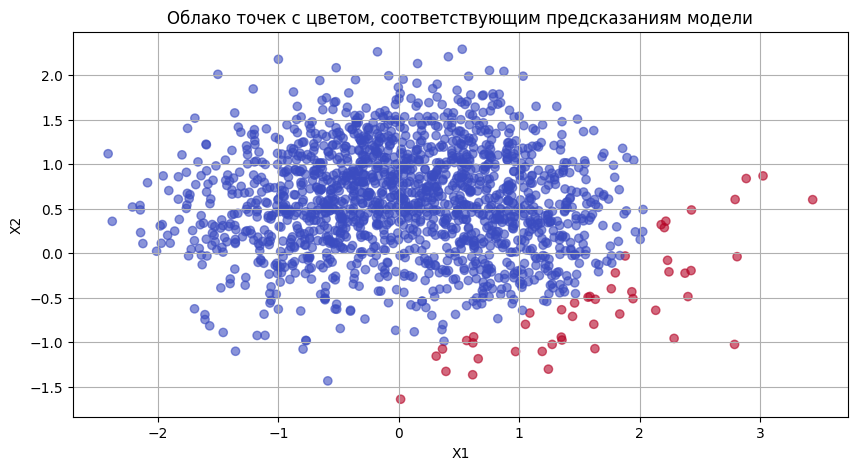

In [46]:
plt.figure(figsize=(10, 5))
plt.scatter(dataset[:][0][:, 0], dataset[:][0][:, 1], c=y_pred, cmap='coolwarm', alpha=0.6)
plt.title('Облако точек с цветом, соответствующим предсказаниям модели')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.show()

In [62]:
y_pos = y.count_nonzero() / y.shape[0]
y_neg = 1 - y_pos
y_pos, y_neg

(tensor(0.0909), tensor(0.9091))

In [66]:
model = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 2)
)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss(weight=th.tensor([y_pos, y_neg]))

In [67]:
losses = train(model, criterion, optimizer, dataloader_train, 2500, 500)
# plot(losses)

Epoch [0/2500], Loss: 0.6597
Epoch [500/2500], Loss: 0.5166
Epoch [1000/2500], Loss: 0.3507
Epoch [1500/2500], Loss: 0.3510
Epoch [2000/2500], Loss: 0.5461
Epoch [2500/2500], Loss: 0.4171


In [68]:
get_metrics(model, dataset_train, dataset_test)

DATASET_TRAIN:
BinaryAccuracy: 0.8038
BinaryPrecision: 0.3000
BinaryRecall: 0.8293
BinaryF1Score: 0.4406

DATASET_TEST:
BinaryAccuracy: 0.8212
BinaryPrecision: 0.2949
BinaryRecall: 0.8519
BinaryF1Score: 0.4381


In [69]:
y_pred = model(dataset[:][0]).argmax(dim=1)
y_pred.shape

torch.Size([1650])

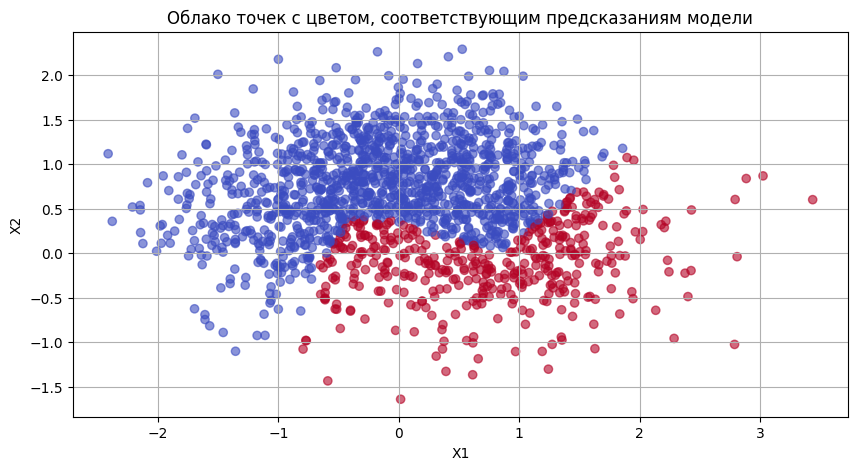

In [70]:
plt.figure(figsize=(10, 5))
plt.scatter(dataset[:][0][:, 0], dataset[:][0][:, 1], c=y_pred, cmap='coolwarm', alpha=0.6)
plt.title('Облако точек с цветом, соответствующим предсказаниям модели')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.show()

<p class="task" id="5"></p>

5\. Повторите решение задачи 4, повысив качество модели за счет использования `WeightedRandomSampler` вместо модификации функции потерь.

- [x] Проверено на семинаре

In [53]:
from torch.utils.data import WeightedRandomSampler

In [54]:
train_labels = dataset_train[:][1]
class_counts = th.bincount(train_labels)
class_weights = 1.0 / class_counts.float()
train_sample_weights = class_weights[train_labels]
sampler = WeightedRandomSampler(weights=train_sample_weights, num_samples=len(train_sample_weights), replacement=True)

In [55]:
dataset = TensorDataset(X, y)
dataset_train, dataset_test = random_split(dataset, [0.8, 0.2])
dataloader_train, dataloader_test = \
    DataLoader(dataset_train, batch_size=125, sampler=sampler), \
    DataLoader(dataset_test, batch_size=125, sampler=sampler)

In [56]:
model = nn.Sequential(
    nn.Linear(2, 10),
    nn.ReLU(),
    nn.Linear(10, 2)
)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [57]:
losses = train(model, criterion, optimizer, dataloader_train, 2500, 500)
# plot(losses)

Epoch [0/2500], Loss: 0.7082
Epoch [500/2500], Loss: 0.2776
Epoch [1000/2500], Loss: 0.3146
Epoch [1500/2500], Loss: 0.2706
Epoch [2000/2500], Loss: 0.2664
Epoch [2500/2500], Loss: 0.1594


In [58]:
get_metrics(model, dataset_train, dataset_test)

DATASET_TRAIN:
BinaryAccuracy: 0.9227
BinaryPrecision: 0.7333
BinaryRecall: 0.2683
BinaryF1Score: 0.3929

DATASET_TEST:
BinaryAccuracy: 0.9303
BinaryPrecision: 0.7000
BinaryRecall: 0.2593
BinaryF1Score: 0.3784


In [59]:
y_pred = model(dataset[:][0]).argmax(dim=1)
y_pred.shape

torch.Size([1650])

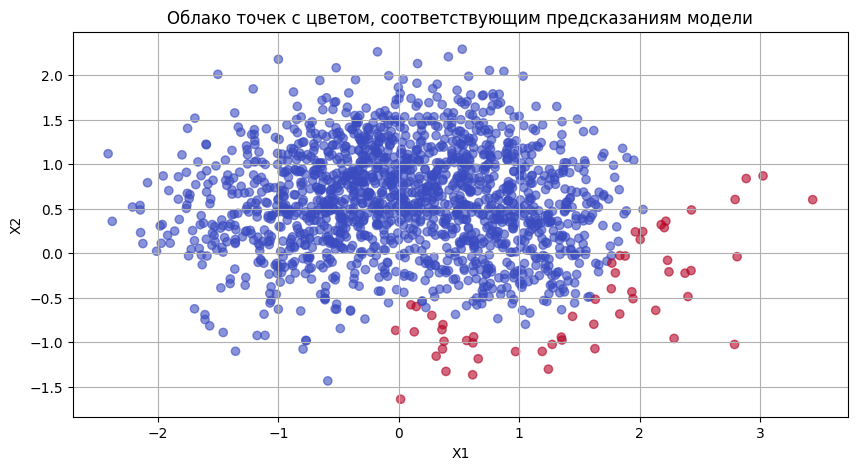

In [60]:
plt.figure(figsize=(10, 5))
plt.scatter(dataset[:][0][:, 0], dataset[:][0][:, 1], c=y_pred, cmap='coolwarm', alpha=0.6)
plt.title('Облако точек с цветом, соответствующим предсказаниям модели')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.show()